<a href="https://www.kaggle.com/code/yahyasoker/review-to-rating-prediction-nlp?scriptVersionId=155685486" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd

In [2]:
# loading data
df = pd.read_csv("/kaggle/input/360k-home-workout-app-google-store-reviews/HOMEWORKOUT_REVIEWS.csv")

In [3]:
#looking to data
df.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,cf3f0c79-e1be-4b20-ab8a-9264bf2c9acd,152618553977019693742,A Google user,عالی هست باعث انگیزه میشه,5,4,1.0.1,2017-11-09 17:14:45
1,1,a19f2d6b-f8b8-4ec5-88f7-c8efa24c47ff,234382942865437071667,A Google user,Nice,5,0,NaN,2017-11-17 16:00:41
2,2,ba77d972-b81a-44aa-9045-c435ed3480ca,174473604608358796368,A Google user,Halp full,2,19,1.0.2,2017-11-21 10:31:08
3,3,d6c98a05-33d5-4751-a6c3-41903bc81e26,286593453219054880269,A Google user,help full,5,10,1.0.2,2017-11-21 12:52:26
4,4,7706f193-282e-4cab-babb-e283ca346509,167276875678680630145,A Google user,Better,5,1,NaN,2017-11-21 17:47:06


In [4]:
# drop unnecessary columns 
columns_to_drop = ['pseudo_author_id', 'Unnamed: 0', 'author_name', 'author_app_version', 'review_timestamp', 'review_id']
df = df.drop(columns=columns_to_drop)

In [5]:
df.head()

,review_text,review_rating,review_likes
0,عالی هست باعث انگیزه میشه,5,4
1,Nice,5,0
2,Halp full,2,19
3,help full,5,10
4,Better,5,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355950 entries, 0 to 355949
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   review_text    355944 non-null  object
 1   review_rating  355950 non-null  int64 
 2   review_likes   355950 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


In [7]:
# Select a random subset of 10,000 rows
subset_df = df.sample(n=10000, random_state=42)

# Alternatively, you can select the first 10,000 rows
#subset_df = df.head(10000)

# Resetting index if needed
subset_df.reset_index(drop=True, inplace=True)

In [8]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_text    10000 non-null  object
 1   review_rating  10000 non-null  int64 
 2   review_likes   10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [9]:
# text cleaning 
import re

def clean_text(text):
    # Convert to string
    text = str(text)
    # Remove special characters and digits
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # Convert all characters to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [10]:
#y = what we'll predict , x = how we'll predict y
y = subset_df['review_rating']
x = subset_df['review_text'].apply(lambda x: clean_text(x))

In [11]:
x,y

(0                                                  out of
 1       this app is really good im at my st day and im...
 2       this experience has helped my muscle and fitne...
 3       amazing beautiful revolutionary showstopping n...
 4                                                        
                               ...                        
 9995                                                 nice
 9996                            nice for doing excriseing
 9997                                                 good
 9998                                             good app
 9999                       very intriguing love it so far
 Name: review_text, Length: 10000, dtype: object,
 0       5
 1       5
 2       5
 3       5
 4       5
        ..
 9995    5
 9996    4
 9997    5
 9998    5
 9999    5
 Name: review_rating, Length: 10000, dtype: int64)

In [12]:
# Import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# test_size=0.2 means that 20% of the data will be used for testing, and 80% for training
# random_state=42 ensures reproducibility of the split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# Import the Tokenizer class from Keras
from keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()

# Build the vocabulary based on the training dataset
tokenizer.fit_on_texts(x_train)

# Tokenize the training and test datasets
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Vocabulary size (number of unique words) -> will be used in the embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [14]:
# Import the pad_sequences function from Keras
from keras.preprocessing.sequence import pad_sequences

# Find the maximum length of sequences in the training set
max_length = max(len(seq) for seq in x_train)

# Check for outliers in the test set and print any sequences that exceed the maximum length
for x in x_test:
    if len(x) > max_length:
        print(f"An outlier detected: {x}")

# Pad sequences to have a uniform length (max_length)
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)

In [15]:
# Import the to_categorical function from Keras utils
from keras.utils import to_categorical

# Convert the categorical labels to one-hot encoded format for both training and testing sets
# 'num_classes=6' indicates the number of classes in the classification task
y_test = to_categorical(y_test, num_classes=6)
y_train = to_categorical(y_train, num_classes=6)

In [16]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense


# Simple recall function
def recall(y_true, y_pred):
    true_pos = K.sum(K.round(y_true * y_pred))
    pos_labels = K.sum(K.round(y_true))
    recall = true_pos / (pos_labels + K.epsilon())
    return recall

# Simple precision function
def precision(y_true, y_pred):
    true_pos = K.sum(K.round(y_true * y_pred))
    pred_pos = K.sum(K.round(y_pred))
    precision = true_pos / (pred_pos + K.epsilon())
    return precision

# Simple F1 score function using the above functions
def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2 * (precisions * recalls) / (precisions + recalls + K.epsilon())

# Define output dimension
output_dim = 360

# Create LSTM model architecture (CNN + LSTM)
model = Sequential([
    Embedding(vocab_size, output_dim, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(6, activation="softmax"),
])

# Compile the model with specified metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1, precision, recall])

# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 360)          1529640   
                                                                 
 lstm (LSTM)                 (None, 64)                108800    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [17]:
# Train the model
model_history = model.fit(
    x_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
125/125 [==============================] - 39s 283ms/step - loss: 0.5401 - accuracy: 0.8984 - f1: 0.8396 - precision: 0.8570 - recall: 0.8354 - val_loss: 0.3707 - val_accuracy: 0.9190 - val_f1: 0.9209 - val_precision: 0.9209 - val_recall: 0.9209
Epoch 2/10
125/125 [==============================] - 34s 275ms/step - loss: 0.3868 - accuracy: 0.9144 - f1: 0.9148 - precision: 0.9161 - recall: 0.9135 - val_loss: 0.3649 - val_accuracy: 0.9190 - val_f1: 0.9197 - val_precision: 0.9224 - val_recall: 0.9170
Epoch 3/10
125/125 [==============================] - 35s 282ms/step - loss: 0.3505 - accuracy: 0.9144 - f1: 0.9175 - precision: 0.9248 - recall: 0.9104 - val_loss: 0.3945 - val_accuracy: 0.9190 - val_f1: 0.9178 - val_precision: 0.9246 - val_recall: 0.9111
Epoch 4/10
125/125 [==============================] - 35s 284ms/step - loss: 0.3178 - accuracy: 0.9145 - f1: 0.9197 - precision: 0.9298 - recall: 0.9099 - val_loss: 0.3938 - val_accuracy: 0.9190 - val_f1: 0.9167 - val_precision: 

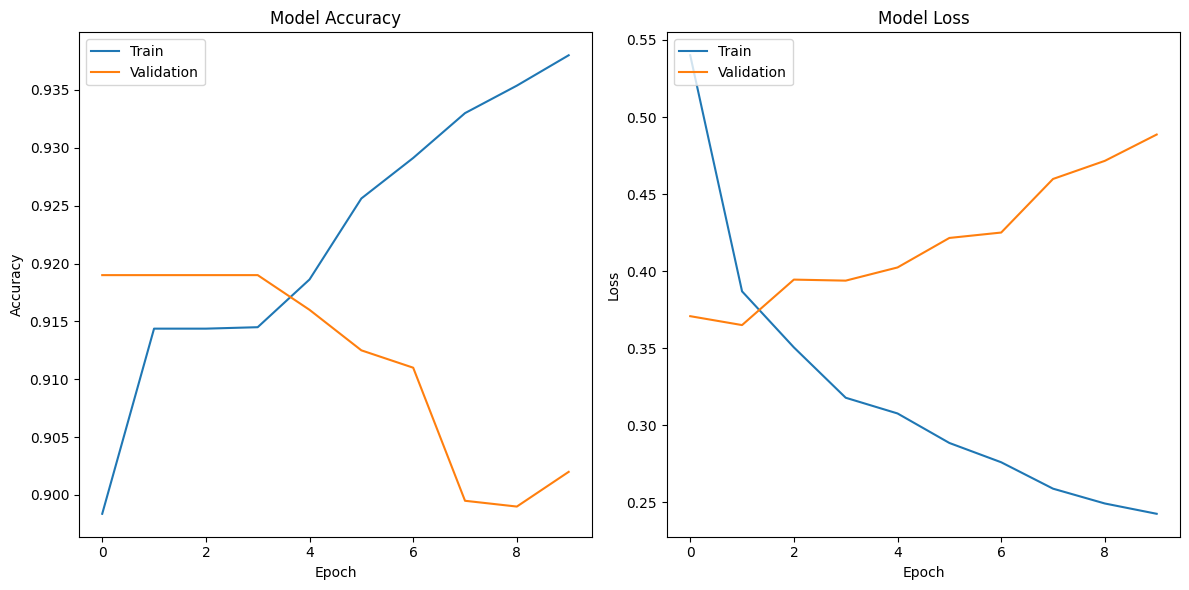

In [18]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(model_history)